### Movie with u, v, w, $\rho$, tr, vorticity alongshore section

In [3]:
#KRM
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
#from MITgcmutils import rdmds # not working
#%matplotlib inline
import os
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import struct
import xarray as xr
import canyon_tools.readout_tools as rout

## Functions

In [4]:
def rel_vort(x,y,u,v):
    """-----------------------------------------------------------------------------
    rel_vort calculates the z component of relative vorticity.
    
    INPUT:
    x,y,u,v should be at least 2D arrays in coordinate order (..., Y , X ) 
    
    OUTPUT:
    relvort - z-relative vorticity array of size u[...,2:-2,2:-2]
    -----------------------------------------------------------------------------"""
    
    dvdx = (v[...,1:-1, 2:]-v[...,1:-1, :-2])/(x[...,1:-1, 2:]-x[...,1:-1, :-2])
    dudy = (u[...,2:,1:-1]-u[..., :-2,1:-1])/(y[..., 2:,1:-1]-y[..., :-2,1:-1])
    relvort = dvdx - dudy
    return relvort


def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be at least 2D arrays in coordinate order (..., Y , X ) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[...,:,:]) + beta*(S[...,:,:]))
    return rho

def call_unstag(t):
    UU,VV = rout.unstagger(state.U.isel(T=t),state.V.isel(T=t))
    return(UU,VV)


def call_rho(t):
    T = state.Temp.isel(T=t,Y=yind)
    S = state.S.isel(T=t,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

## Frame functions

In [19]:
# if y = 230, z from 0 to 56
# if y=245, z from 0 to 47 
# if y=260, z from 0 to 30 

# ALONGSHORE VELOCITY   
def Plot1(t,ax1,UU):
    umin = -0.55 # 0.50
    umax= 0.55
    Uplot=np.ma.array(UU.isel(Y=yind).data,mask=MaskC[:,yind,:])
    csU = np.linspace(umin,umax,num=20)
    csU2 = np.linspace(umin,umax,num=10)
    ax1.clear()
    #mesh=ax1.contourf(grid.X/1000,grid.Z[:47],Uplot[:47,:],csU,cmap='RdYlBu_r') # full shelf
    mesh=ax1.contourf(grid.X[120:240]/1000,grid.Z[:47],Uplot[:47,120:240],csU,cmap='RdYlBu_r') # zoom canyon
    
    if t == 1:    
        cax,kw = mpl.colorbar.make_axes([ax1],location='top',anchor=(0.5,0.0),shrink=0.96)
        cb = plt.colorbar(mesh, cax=cax,ticks=[np.linspace(umin, umax,8) ],format='%.2f',**kw)
       
    ax1.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax1.set_ylabel('Depth (m)')
    ax1.text(0.7,0.1,'u ($m/s$)',transform=ax1.transAxes)

# ACROSS-SHORE VELOCITY    
def Plot2(t,ax2,VV):
    vmin = -0.25
    vmax = 0.25
    Uplot=np.ma.array(VV.isel(Yp1=yind).data,mask=MaskC[:,yind,:])
    csU = np.linspace(vmin,vmax,num=20)
    csU2 = np.linspace(vmin,vmax,num=10)
    ax2.clear()
    #mesh=ax2.contourf(grid.X/1000,grid.Z[:47],Uplot[:47,:],csU,cmap='RdYlBu_r') # full shelf
    mesh=ax2.contourf(grid.X[120:240]/1000,grid.Z[:47],Uplot[:47,120:240],csU,cmap='RdYlBu_r') # canyon zoom
    
    if t == 1:    
        cax,kw = mpl.colorbar.make_axes([ax2],location='top',anchor=(0.5,0.0),shrink=0.96)
        cb = plt.colorbar(mesh, cax=cax,ticks=[np.linspace(vmin,vmax,8) ],format='%.2f',**kw)
        
    ax2.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax2.text(0.7,0.1,'v ($m/s$)',transform=ax2.transAxes)

# VERTICAL VELOCITY    
def Plot3(t,ax3):    
    wmin = -3.0
    wmax = 3.0
    Uplot=np.ma.array(state.W.isel(T=t,Y=yind).data,mask=MaskC[:,yind,:])
    csU = np.linspace(wmin,wmax,num=20)
    csU2 = np.linspace(wmin,wmax,num=10)
    ax3.clear()
    #mesh=ax3.contourf(grid.X/1000,grid.Z[:47],Uplot[:47,:]*1000,csU,cmap='RdYlBu_r')
    mesh=ax3.contourf(grid.X[120:240]/1000,grid.Z[:47],Uplot[:47,120:240]*1000,csU,cmap='RdYlBu_r')
    
    if t == 1:    
        cax,kw = mpl.colorbar.make_axes([ax3],location='top',anchor=(0.5,0.0),shrink=0.96)
        cb = plt.colorbar(mesh, cax=cax,ticks=[np.linspace(wmin,wmax,8) ],format='%.1f',**kw)
        
    ax3.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax3.text(0.6,0.1,'w ($10^{-3}$ $m/s$)',transform=ax3.transAxes)
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax3.text(1.05,0.86,'day %0.1f' %(t/2.0),fontsize=20,transform=ax3.transAxes,bbox=props)

# ISOPYCNALS
def Plot4(t,ax4):
    rho_min = 1020.4 # 1020.4
    rho_max = 1021.9 # 1022.4 if y=230,1021.4 if y=260,1021.9 if y=245
    density = call_rho(t)
    csU = np.linspace(rho_min,rho_max,num=21) #21
    csU2 = np.linspace(rho_min,rho_max,num=31) #31
    ax4.clear()
    #mesh=ax4.contourf(grid.X/1000,grid.Z[:47],
    #                   np.ma.array(density[:47,:].data,mask=MaskC[:47,yind,:]),
    #                  csU,cmap='inferno')
    mesh=ax4.contourf(grid.X[120:240]/1000,grid.Z[:47],
                      np.ma.array(density[:47,120:240].data,mask=MaskC[:47,yind,120:240]),
                      csU,cmap='inferno')
    
    if t == 1:
        cax,kw = mpl.colorbar.make_axes([ax4],location='top',anchor=(0.5,0),shrink=0.96)
        cb = plt.colorbar(mesh, cax=cax,ticks=[np.linspace(rho_min,rho_max,6) ],format='%.1f',**kw)
        
    #CS = ax4.contour(grid.X/1000,grid.Z[:47],
    #                 np.ma.array(density[:47,:].data,mask=MaskC[:47,yind,:]),
    #                 csU2,colors='k',linewidths=[0.75] )
    CS = ax4.contour(grid.X[120:240]/1000,grid.Z[:47],
                     np.ma.array(density[:47,120:240].data,mask=MaskC[:47,yind,120:240]),
                     csU2,colors='k',linewidths=[0.75] )
    
    ax4.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax4.text(0.6,0.1,r'$\rho$ ($kg/m^{3}$)',transform=ax4.transAxes)
    ax4.set_ylabel('Depth (m)')
    ax4.set_xlabel('Alongshore distance (km)')

# TRACER    
def Plot5(t,ax5):    
    tr_min = 0
    tr_max = 20 # 21 if y=230, 12 if y=260, 17 if y=245
    csU = np.linspace(tr_min,tr_max,num=25)
    csU2 = np.linspace(tr_min,tr_max,num=13)
    ax5.clear()
    #mesh=ax5.contourf(grid.X/1000,grid.Z[:47],
    #                  np.ma.array(ptracers.Tr1[t,:47,yind,:].data,mask=MaskC[:47,yind,:]),
    #                  csU,cmap='viridis')
    mesh=ax5.contourf(grid.X[120:240]/1000,grid.Z[:47],
                      np.ma.array(ptracers.Tr1[t,:47,yind,120:240].data,mask=MaskC[:47,yind,120:240]),
                      csU,cmap='viridis')
    
    if t == 1:
        cax,kw = mpl.colorbar.make_axes([ax5],location='top',anchor=(0.5,0),shrink=0.96)
        cb = plt.colorbar(mesh, cax=cax,ticks=[np.linspace(tr_min,tr_max,9) ],format='%.1f',**kw)
        
    #CS = ax5.contour(grid.X/1000,grid.Z[:47],
    #                 np.ma.array(ptracers.Tr1[t,:47,yind,:].data,mask=MaskC[:47,yind,:]),
    #                 csU2,colors='k',linewidths=[0.75] )
    CS = ax5.contour(grid.X[120:240]/1000,grid.Z[:47],
                     np.ma.array(ptracers.Tr1[t,:47,yind,120:240].data,mask=MaskC[:47,yind,120:240]),
                     csU2,colors='k',linewidths=[0.75] )
    ax5.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax5.text(0.6,0.1,'tracer ($Mol/l$)',transform=ax5.transAxes)
    ax5.set_xlabel('Alongshore distance (km)')

# VORTICITY
def Plot6(t,ax6,UU,VV):
    vort_min = -40
    vort_max = 40
    relvort = rel_vort(grid.XC.data,grid.YC.data,UU.data,VV.data)
    Uplot=np.ma.array(relvort[:,yind-1,:],mask=MaskC[:,yind,1:-1])
    csU = np.linspace(vort_min,vort_max,num=20)
    csU2 = np.linspace(vort_min,vort_max,num=10)
    ax6.clear()
    #mesh=ax6.contourf(grid.X[1:-1]/1000,grid.Z[:47],Uplot[:47,:]*1E5,
    #                  csU,
    #                  cmap='PiYG_r')
    mesh=ax6.contourf(grid.X[120:240]/1000,grid.Z[:47],Uplot[:47,120:240]*1E5,
                      csU,
                      cmap='PiYG_r')
    
    if t == 1:    
        cax,kw = mpl.colorbar.make_axes([ax6],location='top',anchor=(0.5,0.0),shrink=0.96)
        cb = plt.colorbar(mesh, cax=cax,
                          ticks=[np.linspace(vort_min,vort_max,8) ],
                          format='%.1f',**kw)
        
    ax6.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax6.text(0.6,0.1,'$\zeta$ ($10^{-5}$ $1/s$)',transform=ax6.transAxes)
    ax6.set_xlabel('Alongshore distance (km)')
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax6.text(1.05,0.1,'Near \n mid-length',fontsize=15,transform=ax6.transAxes,bbox=props)
    


## Set-up

In [20]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run52/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run52/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run52/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

#RhoRef = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/RhoRef'))
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [21]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

yind = 245 # y index for alongshore cross-section

hFacmasked = np.ma.masked_values(grid.HFacC.data, 0)
MaskC = np.ma.getmask(hFacmasked)
    
    

In [22]:
import matplotlib.animation as animation

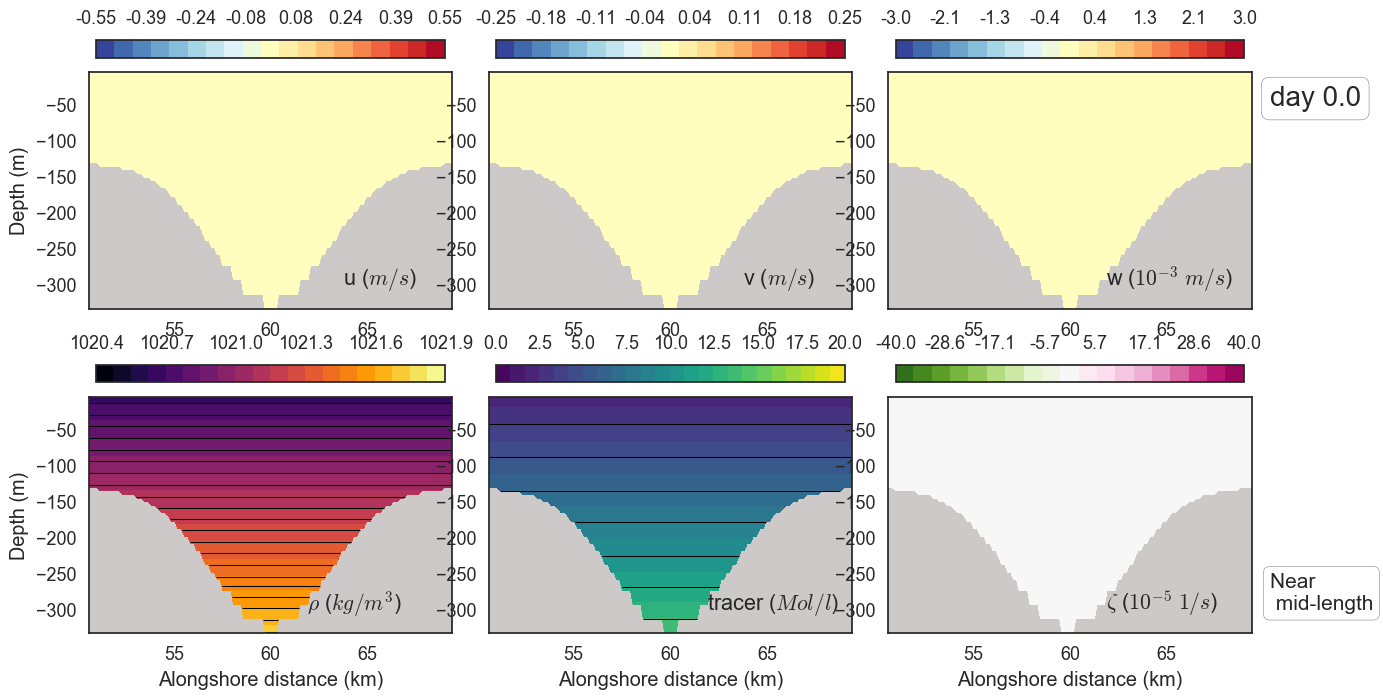

In [24]:
sns.set_style('white')
sns.set_context("talk")

#Empty figures
fig,((ax1,ax2,ax3),(ax4, ax5,ax6)) = plt.subplots(2, 3, figsize=(15, 8),sharex='col', sharey='row')
plt.subplots_adjust(hspace =0.1, wspace=0.1)

#Initial image
def init():
    UU,VV = call_unstag(0)
    Plot1(0,ax1,UU)
    Plot2(0,ax2,VV)
    Plot3(0,ax3)
    Plot4(0,ax4)
    Plot5(0,ax5)
    Plot6(0,ax6,UU,VV)
    #plt.tight_layout()
    
def animate(tt):
    UU,VV = call_unstag(tt)
    Plot1(tt,ax1,UU)
    Plot2(tt,ax2,VV)
    Plot3(tt,ax3)
    Plot4(tt,ax4)
    Plot5(tt,ax5)
    Plot6(tt,ax6,UU,VV)
    xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels() + ax3.get_xticklabels()
    plt.setp(xticklabels, visible=False)
    yticklabels = ax2.get_yticklabels() + ax3.get_yticklabels() + ax5.get_yticklabels() + ax6.get_yticklabels()
    plt.setp(yticklabels, visible=False)


Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)


anim = animation.FuncAnimation(fig, animate, init_func=init,frames=19,repeat=False)
anim.save('CNTDIFF_run52_alongshore_section_y245_ZOOM.mp4', writer=writer)

plt.show()

